In [19]:
import os
import matplotlib.pyplot as plt
import numpy as np
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(3) 
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score
import itertools
import keras
from keras.utils.np_utils import to_categorical #etiketleri one-hot encoding icin degistircez
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.wrappers.scikit_learn import KerasClassifier
from keras.applications.inception_v3 import InceptionV3
from keras import backend as K 
import random
import urllib.request
import matplotlib.image as mpimg
%matplotlib inline
from skimage.filters import rank, threshold_otsu
from skimage import io
from skimage.color import rgb2gray
from sklearn.cluster import KMeans
from skimage.morphology import closing, square, disk

In [20]:
benignTrainPath = 'data/train/benign' # train benign fotolarinin dosya yolunu belirttik 
malignantTrainPath = 'data/train/malignant' # train malignant fotolarinin dosya yolunu belirttik 

benignTestPath = 'data/test/benign' # test benign fotolarının dosya yolunu belirttik
malignantTestPath = 'data/test/malignant' # test malignant fotolarının dosya yolunu belirttik

read = lambda imname: np.asarray(Image.open(imname).convert("RGB")) # numpy arrayına cevircek lambda fonksiyonunu yazdik

In [21]:
ims_benign = [read(os.path.join(benignTrainPath, filename)) for filename in os.listdir(benignTrainPath)]
X_benign = np.array(ims_benign, dtype='uint8') # train datasetimizi hazırladık
ims_malignant = [read(os.path.join(malignantTrainPath, filename)) for filename in os.listdir(malignantTrainPath)]
X_malignant = np.array(ims_malignant, dtype='uint8')

In [22]:
ims_benign = [read(os.path.join(benignTestPath, filename)) for filename in os.listdir(benignTestPath)]
X_benign_test = np.array(ims_benign, dtype='uint8') # test datasetimizi hazirladik
ims_malignant = [read(os.path.join(malignantTestPath, filename)) for filename in os.listdir(malignantTestPath)]
X_malignant_test = np.array(ims_malignant, dtype='uint8')

In [23]:

y_benign = np.zeros(X_benign.shape[0]) # benign'ler 0 malignant'lar 1 olacak şekilde verilerimizi etiketliyoruz
y_malignant = np.ones(X_malignant.shape[0])

In [24]:
print(y_benign)
print(y_malignant)

[0. 0. 0. ... 0. 0. 0.]
[1. 1. 1. ... 1. 1. 1.]


In [25]:
y_benign_test = np.zeros(X_benign_test.shape[0])
y_malignant_test = np.ones(X_malignant_test.shape[0])

print(y_benign_test.shape) # test setimizin büyüklüğünü gösteriyoruz.
print(y_malignant_test.shape)

(360,)
(300,)


In [26]:

X_train = np.concatenate((X_benign, X_malignant), axis = 0) # benign ve malignant trainleri birleştirerek train datamizi oluşturuyoruz
y_train = np.concatenate((y_benign, y_malignant), axis = 0)

In [27]:
print(X_train.shape)

print(y_train.shape)

(2637, 224, 224, 3)
(2637,)


In [28]:
X_test = np.concatenate((X_benign_test, X_malignant_test), axis = 0) # test datalarimizi olusturuyoruz
y_test = np.concatenate((y_benign_test, y_malignant_test), axis = 0)

In [29]:
print("X_test'in boyutu ",X_test.shape)

print("Y_test'in boyutu ",y_test.shape)

X_test'in boyutu  (660, 224, 224, 3)
Y_test'in boyutu  (660,)


In [30]:
# verimizi karistiriyoruz
s = np.arange(X_train.shape[0]) 
np.random.shuffle(s)
X_train = X_train[s]
y_train = y_train[s]

In [31]:
s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
y_test = y_test[s]

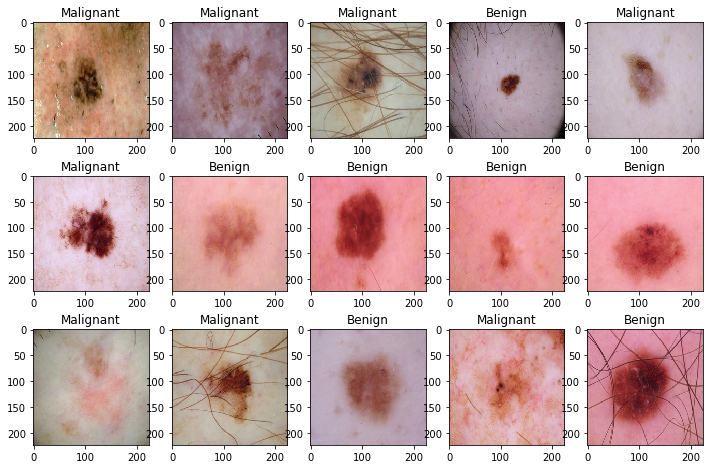

In [32]:
# ilk 15 resmi ve nasıl etiketlendigine bakalim
w=40
h=40
fig=plt.figure(figsize=(12, 8))
columns = 5
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if y_train[i] == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(X_train[i], interpolation='nearest')
plt.show()

In [33]:
y_train = to_categorical(y_train, num_classes= 2) #kategorik'e ceviriyoruz
y_test = to_categorical(y_test, num_classes= 2)

In [34]:
print(y_train.shape)
print(y_test.shape)

(2637, 2)
(660, 2)


In [35]:
print(X_train)
print(X_test)


[[[[202 146 145]
   [203 148 143]
   [204 149 146]
   ...
   [207 133 130]
   [207 129 129]
   [205 131 132]]

  [[210 152 148]
   [205 150 145]
   [204 146 144]
   ...
   [205 127 123]
   [204 123 120]
   [206 131 128]]

  [[208 150 148]
   [205 150 145]
   [204 146 142]
   ...
   [199 121 111]
   [203 115 113]
   [205 124 120]]

  ...

  [[205 149 150]
   [206 152 152]
   [208 154 154]
   ...
   [203 132 128]
   [206 126 125]
   [206 132 129]]

  [[207 151 152]
   [207 153 153]
   [209 153 154]
   ...
   [203 132 128]
   [202 122 121]
   [207 128 124]]

  [[206 155 154]
   [208 154 154]
   [208 154 152]
   ...
   [203 132 128]
   [203 125 123]
   [204 123 120]]]


 [[[152 143 104]
   [189 183 149]
   [183 182 152]
   ...
   [154 121  78]
   [158 123  83]
   [151 115  79]]

  [[190 178 140]
   [186 178 142]
   [188 185 154]
   ...
   [154 122  81]
   [158 124  86]
   [156 122  84]]

  [[194 179 138]
   [188 178 142]
   [187 184 151]
   ...
   [154 122  81]
   [159 125  87]
   [160 126

In [36]:

X_train = X_train/255.
X_test = X_test/255.

print(X_train)
print(X_test)

[[[[0.79215686 0.57254902 0.56862745]
   [0.79607843 0.58039216 0.56078431]
   [0.8        0.58431373 0.57254902]
   ...
   [0.81176471 0.52156863 0.50980392]
   [0.81176471 0.50588235 0.50588235]
   [0.80392157 0.51372549 0.51764706]]

  [[0.82352941 0.59607843 0.58039216]
   [0.80392157 0.58823529 0.56862745]
   [0.8        0.57254902 0.56470588]
   ...
   [0.80392157 0.49803922 0.48235294]
   [0.8        0.48235294 0.47058824]
   [0.80784314 0.51372549 0.50196078]]

  [[0.81568627 0.58823529 0.58039216]
   [0.80392157 0.58823529 0.56862745]
   [0.8        0.57254902 0.55686275]
   ...
   [0.78039216 0.4745098  0.43529412]
   [0.79607843 0.45098039 0.44313725]
   [0.80392157 0.48627451 0.47058824]]

  ...

  [[0.80392157 0.58431373 0.58823529]
   [0.80784314 0.59607843 0.59607843]
   [0.81568627 0.60392157 0.60392157]
   ...
   [0.79607843 0.51764706 0.50196078]
   [0.80784314 0.49411765 0.49019608]
   [0.80784314 0.51764706 0.50588235]]

  [[0.81176471 0.59215686 0.59607843]
   [0.8

In [37]:
print(X_train.shape)

print(X_test.shape)

(2637, 224, 224, 3)
(660, 224, 224, 3)


In [38]:
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Dense, Activation, SimpleRNN
from tensorflow.keras.layers import Flatten, concatenate
from PIL import Image as Img

In [39]:
image_size = X_train.shape[1]
image_size

224

In [40]:
num_labels = len(np.unique(y_train))
print("Label sayisi:",num_labels)

Label sayisi: 2


In [41]:
input_shape = (image_size, image_size, 3) # square grayscale
batch_size = 64
kernel_size = 3
pool_size = 2
filters = 32
#dropout kullanmayacagız

In [42]:
model = Sequential()

model.add(Conv2D(filters=filters,
        kernel_size=kernel_size,
        activation='relu',
        input_shape=input_shape))

model.add(MaxPooling2D(pool_size))
model.add(Conv2D(filters=filters, kernel_size=kernel_size,
        activation='relu'))

model.add(MaxPooling2D(pool_size))
model.add(Conv2D(filters=filters, kernel_size=kernel_size,
        activation='relu'))

model.add(MaxPooling2D(pool_size))
model.add(Conv2D(filters=filters,
        kernel_size=kernel_size,
        activation='relu'))

model.add(Flatten())
# output layer 10-dim
model.add(Dense(num_labels))
model.add(Activation('softmax'))

In [43]:

# adam optimizer kullanilacak
# accuracy classification icin iyi
model.compile(loss='categorical_crossentropy',
optimizer='adam',
metrics=['accuracy'])

In [44]:

history = model.fit(X_train, y_train, epochs=10, batch_size=batch_size)

Epoch 1/10
42/42 [==============================] - 60s 1s/step - loss: 0.6365 - accuracy: 0.6348
Epoch 2/10
42/42 [==============================] - 60s 1s/step - loss: 0.5618 - accuracy: 0.7027
Epoch 3/10
42/42 [==============================] - 60s 1s/step - loss: 0.4613 - accuracy: 0.7725
Epoch 4/10
42/42 [==============================] - 59s 1s/step - loss: 0.4724 - accuracy: 0.7656
Epoch 5/10
42/42 [==============================] - 59s 1s/step - loss: 0.4291 - accuracy: 0.7884
Epoch 6/10
42/42 [==============================] - 59s 1s/step - loss: 0.4067 - accuracy: 0.7945
Epoch 7/10
42/42 [==============================] - 60s 1s/step - loss: 0.4178 - accuracy: 0.7797
Epoch 8/10
42/42 [==============================] - 58s 1s/step - loss: 0.3914 - accuracy: 0.8017
Epoch 9/10
42/42 [==============================] - 58s 1s/step - loss: 0.3961 - accuracy: 0.8047
Epoch 10/10
42/42 [==============================] - 58s 1s/step - loss: 0.4376 - accuracy: 0.7766


dict_keys(['loss', 'accuracy'])


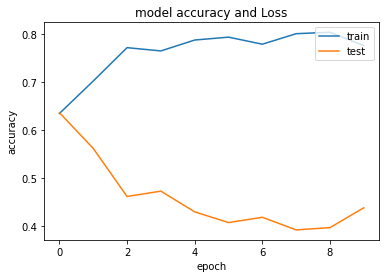

In [45]:

print(history.history.keys())
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.title('model accuracy and Loss')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show() #overfitting var 

In [42]:
# network parametrelerini belirtiyoruz
input_shape = (image_size, image_size, 3) # square grayscale
batch_size = 128
kernel_size = 3
pool_size = 2
filters = 64
dropout = 0.2 bu sefer dropout ekliyoruz

In [43]:
model = Sequential()

model.add(Conv2D(filters=filters,
        kernel_size=kernel_size,
        activation='relu',
        input_shape=input_shape))

model.add(MaxPooling2D(pool_size))
model.add(Conv2D(filters=filters, kernel_size=kernel_size,
        activation='relu'))

model.add(MaxPooling2D(pool_size))
model.add(Conv2D(filters=filters,
        kernel_size=kernel_size,
        activation='relu'))

model.add(Flatten())

model.add(Dropout(dropout))

model.add(Dense(num_labels))
model.add(Activation('softmax'))

In [45]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 64)        36928     
_________________________________________________________________
flatten (Flatten)            (None, 173056)            0         
_________________________________________________________________
dropout (Dropout)            (None, 173056)            0

In [47]:

model.compile(loss='categorical_crossentropy',
optimizer='adam',
metrics=['accuracy'])

In [48]:
# ağı train ediyoruz
history =model.fit(X_train, y_train, epochs=50, batch_size=batch_size)

Epoch 1/50
21/21 [==============================] - 114s 5s/step - loss: 1.2651 - accuracy: 0.5601
Epoch 2/50
21/21 [==============================] - 103s 5s/step - loss: 0.6026 - accuracy: 0.6803
Epoch 3/50
21/21 [==============================] - 103s 5s/step - loss: 0.4676 - accuracy: 0.7702
Epoch 4/50
21/21 [==============================] - 104s 5s/step - loss: 0.4568 - accuracy: 0.7668
Epoch 5/50
21/21 [==============================] - 104s 5s/step - loss: 0.4492 - accuracy: 0.7755
Epoch 6/50
21/21 [==============================] - 103s 5s/step - loss: 0.4331 - accuracy: 0.7793
Epoch 7/50
21/21 [==============================] - 104s 5s/step - loss: 0.4045 - accuracy: 0.7941
Epoch 8/50
21/21 [==============================] - 103s 5s/step - loss: 0.3988 - accuracy: 0.7967
Epoch 9/50
21/21 [==============================] - 103s 5s/step - loss: 0.3785 - accuracy: 0.8093
Epoch 10/50
21/21 [==============================] - 104s 5s/step - loss: 0.3729 - accuracy: 0.8138
Epoch 11/

dict_keys(['loss', 'accuracy'])


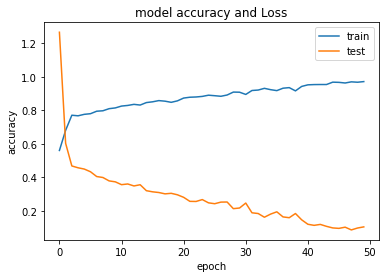

In [64]:

print(history.history.keys())
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.title('model accuracy and Loss')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [51]:
prediction=model.predict(X_test) # x_test'ten tahmin yapacagız

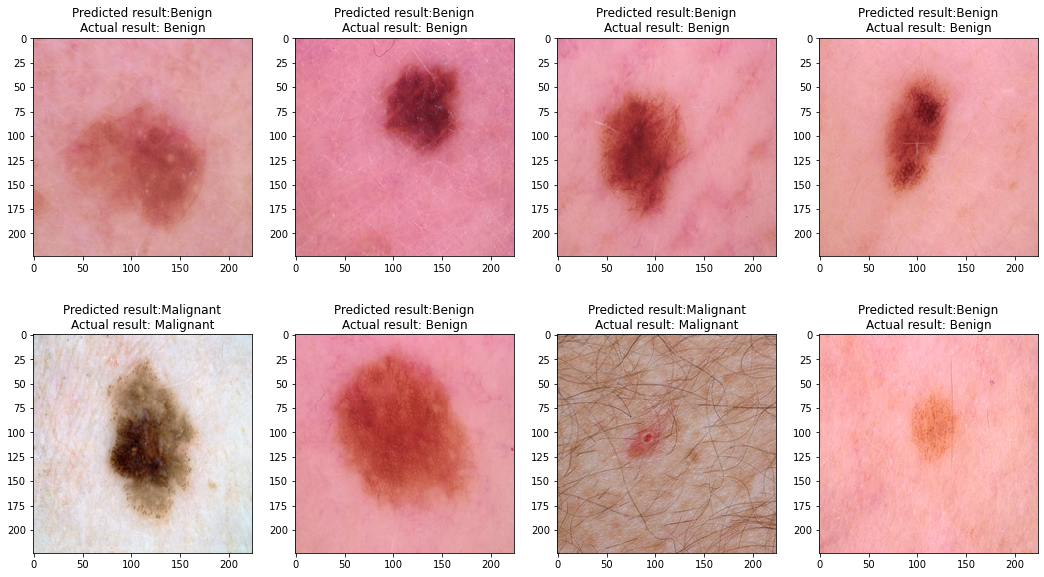

In [52]:
i=0
prop_class=[]
mis_class=[]

for i in range(len(y_test)):
    if(np.argmax(y_test[i])==np.argmax(prediction[i])): #tahmin ile y aynı ise prop_class'a ekliyoruz
        prop_class.append(i)
    if(len(prop_class)==8):
        break

i=0
for i in range(len(y_test)):
    if(not np.argmax(y_test[i])==np.argmax(prediction[i])):
        mis_class.append(i)
    if(len(mis_class)==8):
        break

# benign ilk 8 resmi gosteriyoruz
w=60
h=40
fig=plt.figure(figsize=(18, 10))
columns = 4
rows = 2

def Transfername(namecode):
    if namecode==0:
        return "Benign"
    else:
        return "Malignant"
    
for i in range(len(prop_class)):
    ax = fig.add_subplot(rows, columns, i+1)
    ax.set_title("Predicted result:"+ Transfername(np.argmax(prediction[prop_class[i]]))
                       +"\n"+"Actual result: "+ Transfername(np.argmax(y_test[prop_class[i]])))
    plt.imshow(X_test[prop_class[i]], interpolation='nearest')
plt.show()

In [53]:
from keras.applications.mobilenet_v2 import MobileNetV2

In [54]:
# overfitting engellemek icin learning rate reduction kullanacagız
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=5, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=1e-7)

In [55]:
input_shape = (224,224,3)
lr = 1e-5
epochs = 50
batch_size = 32

model = MobileNetV2(include_top=True,
                 weights= None,
                 input_tensor=None,
                 input_shape=input_shape,
                 pooling=None,
                 classes=2)

model.compile(optimizer = Adam(lr) ,
              loss = "binary_crossentropy", 
              metrics=["accuracy"])

In [56]:
model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

In [58]:
history2 = model.fit(X_train, y_train, validation_split=0.2,
                    epochs= epochs, batch_size= batch_size, verbose=1, 
                    callbacks=[learning_rate_reduction]
                   )

Epoch 1/50
66/66 [==============================] - 285s 4s/step - loss: 0.7967 - accuracy: 0.5571 - val_loss: 0.6917 - val_accuracy: 0.5360
Epoch 2/50
66/66 [==============================] - 283s 4s/step - loss: 0.6607 - accuracy: 0.5974 - val_loss: 0.6909 - val_accuracy: 0.5360
Epoch 3/50
66/66 [==============================] - 284s 4s/step - loss: 0.5727 - accuracy: 0.6776 - val_loss: 0.6906 - val_accuracy: 0.5360
Epoch 4/50
66/66 [==============================] - 284s 4s/step - loss: 0.5089 - accuracy: 0.7349 - val_loss: 0.6909 - val_accuracy: 0.5360
Epoch 5/50
66/66 [==============================] - 284s 4s/step - loss: 0.4867 - accuracy: 0.7610 - val_loss: 0.6924 - val_accuracy: 0.5360
Epoch 6/50
66/66 [==============================] - 285s 4s/step - loss: 0.4637 - accuracy: 0.7700 - val_loss: 0.6949 - val_accuracy: 0.5360
Epoch 7/50
66/66 [==============================] - 284s 4s/step - loss: 0.4503 - accuracy: 0.7696 - val_loss: 0.6973 - val_accuracy: 0.5360
Epoch 8/50
66

66/66 [==============================] - 285s 4s/step - loss: 0.3940 - accuracy: 0.8051 - val_loss: 0.8548 - val_accuracy: 0.5360
Epoch 23/50
66/66 [==============================] - 285s 4s/step - loss: 0.3936 - accuracy: 0.8118 - val_loss: 0.8614 - val_accuracy: 0.5360
Epoch 24/50
66/66 [==============================] - 285s 4s/step - loss: 0.3751 - accuracy: 0.8250 - val_loss: 0.8864 - val_accuracy: 0.5360
Epoch 25/50
66/66 [==============================] - 285s 4s/step - loss: 0.3692 - accuracy: 0.8279 - val_loss: 0.9112 - val_accuracy: 0.5360
Epoch 26/50
66/66 [==============================] - 286s 4s/step - loss: 0.3658 - accuracy: 0.8288 - val_loss: 0.9334 - val_accuracy: 0.5360
Epoch 27/50
66/66 [==============================] - 285s 4s/step - loss: 0.3620 - accuracy: 0.8326 - val_loss: 0.9512 - val_accuracy: 0.5360
Epoch 28/50
66/66 [==============================] - 285s 4s/step - loss: 0.3603 - accuracy: 0.8222 - val_loss: 0.9523 - val_accuracy: 0.5360
Epoch 29/50
66/66 

<AxesSubplot:>

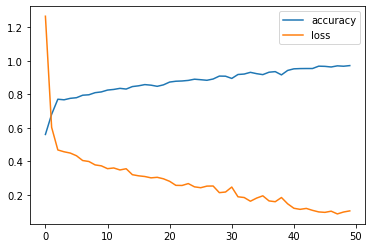

In [59]:
history_df = pd.DataFrame(history.history)
history_df[['accuracy', 'loss']].plot()

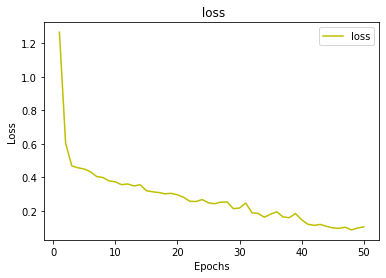

In [60]:
loss = history.history['loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='loss')
plt.title(' loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [61]:
pred = model.predict(X_test)# test görüntüleri yeniden oluşturuluyor


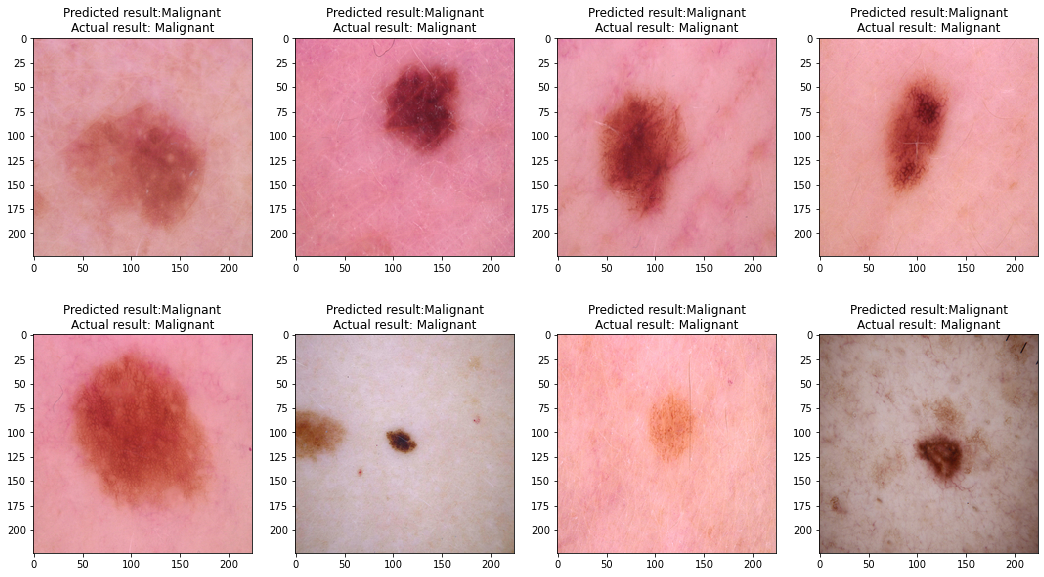

In [62]:
i=0
prop_class=[]
mis_class=[]

for i in range(len(y_test)):
    if(np.argmax(y_test[i])==np.argmax(pred[i])):
        prop_class.append(i)
    if(len(prop_class)==8):
        break

i=0
for i in range(len(y_test)):
    if(not np.argmax(y_test[i])==np.argmax(pred[i])):
        mis_class.append(i)
    if(len(mis_class)==8):
        break

# # Display first 8 images of benign
w=60
h=40
fig=plt.figure(figsize=(18, 10))
columns = 4
rows = 2

def Transfername(namecode):
    if namecode==1:
        return "Benign"
    else:
        return "Malignant"
    
for i in range(len(prop_class)):
    ax = fig.add_subplot(rows, columns, i+1)
    ax.set_title("Predicted result:"+ Transfername(np.argmax(pred[prop_class[i]]))
                       +"\n"+"Actual result: "+ Transfername(np.argmax(y_test[prop_class[i]])))
    plt.imshow(X_test[prop_class[i]], interpolation='nearest')
plt.show()

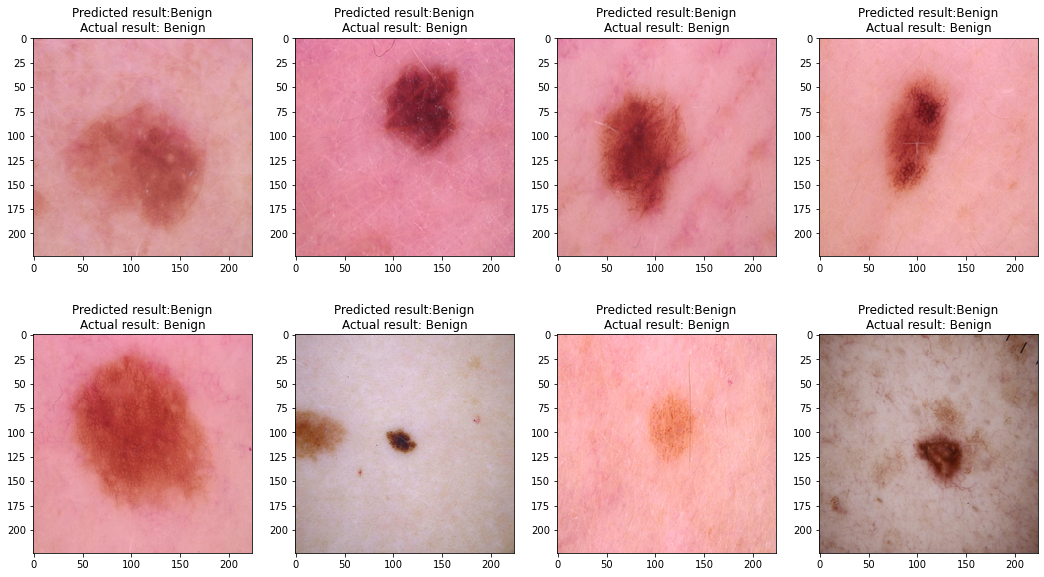

In [63]:
i=0
prop_class=[]
mis_class=[]

for i in range(len(y_test)):
    if(np.argmax(y_test[i])==np.argmax(pred[i])):
        prop_class.append(i)
    if(len(prop_class)==8):
        break

i=0
for i in range(len(y_test)):
    if(not np.argmax(y_test[i])==np.argmax(pred[i])):
        mis_class.append(i)
    if(len(mis_class)==8):
        break

# # ilk 8 görüntüyü bastır
w=60
h=40
fig=plt.figure(figsize=(18, 10))
columns = 4
rows = 2

def Transfername(namecode):
    if namecode==0:
        return "Benign"
    else:
        return "Malignant"
    
for i in range(len(prop_class)):
    ax = fig.add_subplot(rows, columns, i+1)
    ax.set_title("Predicted result:"+ Transfername(np.argmax(pred[prop_class[i]]))
                       +"\n"+"Actual result: "+ Transfername(np.argmax(y_test[prop_class[i]])))
    plt.imshow(X_test[prop_class[i]], interpolation='nearest')
plt.show()